In [1]:
import os
import argparse
import math
import torch
import pickle
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from braceexpand import braceexpand
from tqdm import tqdm
import multiprocessing as mp
from copy import copy

# for flex attention
import torch._dynamo
import torch.multiprocessing as mp 
torch._dynamo.config.suppress_errors = True

sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

2025-03-20 13:22:55.001348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 13:22:58.236811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gene_ontology_infos = dict()

assay_labels = [
    "Seq-Well",
    "10x 3' v3",
    "SPLiT-seq",
    "Smart-seq v4",
    "Drop-seq",
    "sci-RNA-seq",
    "10x 5' v2",
    "10x 5' transcription profiling",
    "inDrop",
    "microwell-seq",
    "10x multiome",
    "10x 3' v1",
    "ScaleBio single cell RNA sequencing",
    "Smart-seq2",
    "10x 3' transcription profiling",
    "Seq-Well S3",
    "10x 3' v2",
    "MARS-seq",
    "10x 5' v1"
]

assay_ontology_term_ids = [
    "EFO:0008919",
    "EFO:0009922",
    "EFO:0009919",
    "EFO:0700016",
    "EFO:0008722",
    "EFO:0010550",
    "EFO:0009900",
    "EFO:0030004",
    "EFO:0008780",
    "EFO:0030002",
    "EFO:0030059",
    "EFO:0009901",
    "EFO:0022490",
    "EFO:0008931",
    "EFO:0030003",
    "EFO:0030019",
    "EFO:0009899",
    "EFO:0008796",
    "EFO:0011025"
]

gene_ontology_infos["assay_ontology_term_id"] = dict()
gene_ontology_infos["assay_ontology_term_id"]["names"] = assay_ontology_term_ids
gene_ontology_infos["assay_ontology_term_id"]["labels"] = assay_labels

gene_ontology_infos["suspension_type"] = dict()
gene_ontology_infos["suspension_type"]["names"] = ["nucleus", "cell"]
gene_ontology_infos["suspension_type"]["labels"] = ["nucleus", "cell"]

In [40]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"

ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
REF_ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/extract_0.h5ad'
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=6-step=63560.ckpt"
DEVICE = 'cuda'

assay_label_map = {
    "10x Chromium (v2) A": "10x 3' v2",
    "10x Chromium (v2) B": "10x 3' v2",
    "10x Chromium (v3)": "10x 3' v3",
    "Drop-seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
    "inDrops": "inDrop"
}

assay_ontology_term_id_map = {
    "Seq-Well": "EFO:0008919",
    "10x 3' v3": "EFO:0009922",
    "Drop-seq": "EFO:0008722",
    "inDrop": "EFO:0008780",
    "10x 3' v2": "EFO:0009899"
}

methods = list(assay_label_map.keys())

In [41]:
ref_adata = sc.read_h5ad(REF_ADATA_FP)
val_adata = sc.read_h5ad(ADATA_FP)

In [76]:
val_adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
253,pbmc1_10x_v2_A_AAAGATGCAAAGTCAA,851,2177,0.0381258612769867,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A
254,pbmc1_10x_v2_A_AAAGCAAGTAGGAGTC,1078,3065,0.0417618270799347,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A
255,pbmc1_10x_v2_A_AAAGCAATCGGTTCGG,538,977,0.0992835209825998,4,CD14+ monocyte,pbmc1,10x Chromium (v2) A
256,pbmc1_10x_v2_A_AAAGTAGTCATTTGGG,1544,4933,0.0427731603486722,5,CD14+ monocyte,pbmc1,10x Chromium (v2) A
257,pbmc1_10x_v2_A_AAAGTAGTCCGAGCCA,632,1487,0.0477471418964358,4,CD14+ monocyte,pbmc1,10x Chromium (v2) A
...,...,...,...,...,...,...,...,...
19580,pbmc1_inDrops_TGGTTAAC-GGAGGTAA-CTCGATGC,1167,2124,0.0649717514124294,4,CD14+ monocyte,pbmc1,inDrops
19581,pbmc1_inDrops_TGGTTAAC-GGAGGTAA-TCACCGAG,413,636,0.10062893081761,5,CD16+ monocyte,pbmc1,inDrops
19582,pbmc1_inDrops_TGGTTAAC-GGAGGTAA-TCATATGG,172,205,0.0829268292682927,0,Cytotoxic T cell,pbmc1,inDrops
19583,pbmc1_inDrops_TGTTATCA-GGAGGTAA-TAAATAGG,309,477,0.132075471698113,2,CD4+ T cell,pbmc1,inDrops


In [77]:
val_adata.X.sum(-1)

matrix([[2171.],
        [3059.],
        [ 970.],
        ...,
        [ 205.],
        [ 471.],
        [ 329.]], dtype=float32)

In [43]:
val_adata.obs.CellType.value_counts()

CellType
Cytotoxic T cell               8878
CD4+ T cell                    7279
CD14+ monocyte                 5490
B cell                         4941
Natural killer cell            1515
Megakaryocyte                   963
CD16+ monocyte                  786
Dendritic cell                  433
Plasmacytoid dendritic cell     164
Unassigned                       46
Name: count, dtype: int64

In [44]:
probs_per_method = {}
for method in methods:
    per_method_adata = val_adata.copy()
    per_method_adata = per_method_adata[per_method_adata.obs.Method == method]
    sorted_counts = list(per_method_adata[per_method_adata.obs.CellType == 'CD4+ T cell'].obs.nUMI.value_counts().sort_index().items())

    max_count = int(sorted_counts[-1][0])
    occurrence_per_count = [0] * (max_count + 1)

    for (count_val, count_occurence) in sorted_counts:
        occurrence_per_count[int(count_val)] = count_occurence

    probs = occurrence_per_count / np.sum(occurrence_per_count)

    probs_per_method[method] = probs

In [45]:
probs_per_method

{'10x Chromium (v2) A': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00181818]),
 '10x Chromium (v2) B': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00110132]),
 '10x Chromium (v3)': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00104167]),
 'Drop-seq': array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.0004852]),
 'Seq-Well': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00176678]),
 'inDrops': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00090009])}

In [46]:
cellarium_var_names = set(ref_adata.var_names)
val_adata = val_adata[:, val_adata.var_names.isin(cellarium_var_names)]
val_adata = val_adata[val_adata.obs.Experiment == 'pbmc1']
val_adata = val_adata[val_adata.obs.Method.isin(list(assay_label_map.keys()))]

In [47]:
per_method_adata = val_adata.copy()
per_method_adata = per_method_adata[per_method_adata.obs.Method == "10x Chromium (v3)"]
sorted_counts = list(per_method_adata[per_method_adata.obs.CellType == 'CD4+ T cell'].obs.nUMI.value_counts().sort_index().items())

len(sorted_counts)

863

In [48]:
max_count = int(sorted_counts[-1][0])
occurrence_per_count = [0] * (max_count + 1)

for (count_val, count_occurence) in sorted_counts:
    occurrence_per_count[int(count_val)] = count_occurence

probs = occurrence_per_count / np.sum(occurrence_per_count)

(array([5.27e+04, 0.00e+00, 7.77e+02, 0.00e+00, 0.00e+00, 7.60e+01,
        0.00e+00, 9.00e+00, 0.00e+00, 1.00e+00]),
 array([0.        , 0.00041667, 0.00083333, 0.00125   , 0.00166667,
        0.00208333, 0.0025    , 0.00291667, 0.00333333, 0.00375   ,
        0.00416667]),
 <BarContainer object of 10 artists>)

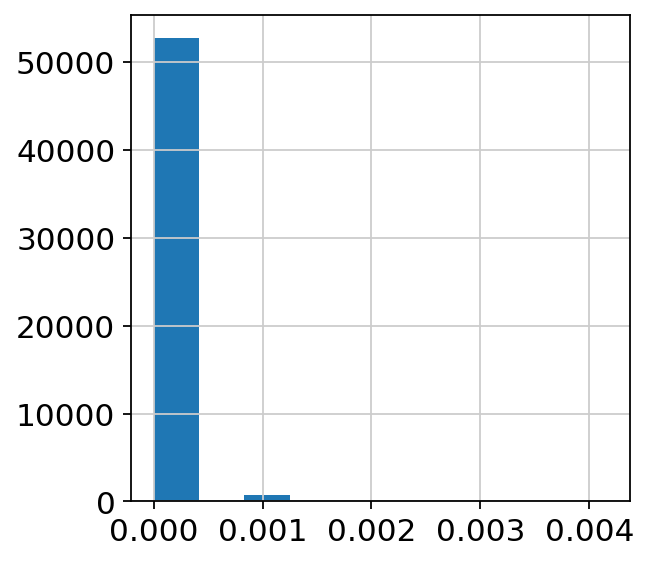

In [49]:
plt.hist(probs)

In [50]:
probs_per_method = {}
for method in methods:
    per_method_adata = val_adata.copy()
    per_method_adata = per_method_adata[per_method_adata.obs.Method == method]
    sorted_counts = list(per_method_adata[per_method_adata.obs.CellType == 'CD4+ T cell'].obs.nUMI.value_counts().sort_index().items())

    max_count = int(sorted_counts[-1][0])
    occurrence_per_count = [0] * (max_count + 1)

    for (count_val, count_occurence) in sorted_counts:
        occurrence_per_count[int(count_val)] = count_occurence

    probs = occurrence_per_count / np.sum(occurrence_per_count)

    probs_per_method[method] = torch.from_numpy(probs)

In [51]:
probs_per_method

{'10x Chromium (v2) A': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0018],
        dtype=torch.float64),
 '10x Chromium (v2) B': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0011],
        dtype=torch.float64),
 '10x Chromium (v3)': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0010],
        dtype=torch.float64),
 'Drop-seq': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0011],
        dtype=torch.float64),
 'Seq-Well': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0023],
        dtype=torch.float64),
 'inDrops': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0020],
        dtype=torch.float64)}

(array([18.,  0.,  0., ...,  0.,  0., 24.]),
 array([  80.        ,   82.23434442,   84.46868885, ..., 4642.53131115,
        4644.76565558, 4647.        ]),
 <BarContainer object of 2044 artists>)

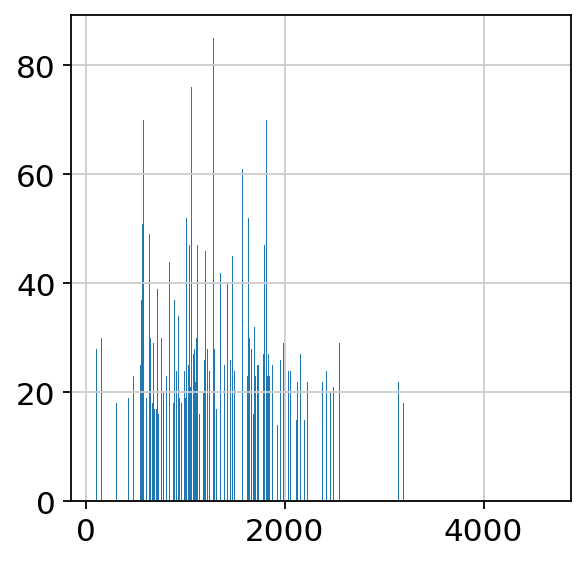

In [52]:
samples = torch.multinomial(probs_per_method['Seq-Well'], num_samples=10000, replacement=True)
plt.hist(samples, bins=len(probs))

In [53]:
new_adata = val_adata.copy()
print(new_adata.shape)
new_adata = new_adata[new_adata.obs.CellType == 'CD4+ T cell']
new_adata.obs

(19332, 32351)


,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
960,pbmc1_10x_v2_A_AACCGCGCAATCTACG,1031,2730,0.0296703296703297,2,CD4+ T cell,pbmc1,10x Chromium (v2) A
961,pbmc1_10x_v2_A_AACCGCGTCATCATTC,833,1921,0.0661114003123373,2,CD4+ T cell,pbmc1,10x Chromium (v2) A
972,pbmc1_10x_v2_A_AAGCCGCTCTAACCGA,1099,3419,0.0295408014039193,2,CD4+ T cell,pbmc1,10x Chromium (v2) A
1095,pbmc1_10x_v2_A_AGGTCCGGTTAAGATG,926,2479,0.0399354578459056,2,CD4+ T cell,pbmc1,10x Chromium (v2) A
1120,pbmc1_10x_v2_A_ATCATCTAGTGTCCAT,1066,3260,0.0306748466257669,2,CD4+ T cell,pbmc1,10x Chromium (v2) A
...,...,...,...,...,...,...,...,...
19561,pbmc1_inDrops_TGGCTAGT-GGAGGTAA-GGTTTCTC,249,390,0.117948717948718,2,CD4+ T cell,pbmc1,inDrops
19562,pbmc1_inDrops_TGGCTAGT-GGAGGTAA-GTTTACGT,332,482,0.0788381742738589,2,CD4+ T cell,pbmc1,inDrops
19571,pbmc1_inDrops_TGGTGTCT-GGAGGTAA-TAGTGTTT,250,367,0.0926430517711172,2,CD4+ T cell,pbmc1,inDrops
19583,pbmc1_inDrops_TGTTATCA-GGAGGTAA-TAAATAGG,309,477,0.132075471698113,2,CD4+ T cell,pbmc1,inDrops


In [54]:
assay = []
suspension_type = []
total_mrna_umis = []
assay_ontology_term_id = []
for idx in range(new_adata.shape[0]):
    assay.append(assay_label_map[new_adata.obs.iloc[idx]['Method']])
    suspension_type.append('cell')
    total_mrna_umis.append(new_adata.obs.iloc[idx]['nUMI'])
    assay_ontology_term_id.append(assay_ontology_term_id_map[assay[-1]])

new_adata.obs['assay'] = assay
new_adata.obs['suspension_type'] = suspension_type
new_adata.obs['total_mrna_umis'] = np.array(total_mrna_umis, dtype=np.int64)
new_adata.obs['assay_ontology_term_id'] = assay_ontology_term_id

/tmp/ipykernel_3059541/3954600670.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  new_adata.obs['assay'] = assay


In [55]:
new_adata

AnnData object with n_obs × n_vars = 4254 × 32351
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'suspension_type', 'total_mrna_umis', 'assay_ontology_term_id'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [56]:
new_adata.obs['cell_type_ontology_term_id'] = '<MASK>'
new_adata.obs['tissue_ontology_term_id'] = '<MASK>'
new_adata.obs['development_stage_ontology_term_id'] = '<MASK>'
new_adata.obs['disease_ontology_term_id'] = '<MASK>'
new_adata.obs['sex_ontology_term_id'] = '<MASK>'

In [18]:
n_cells = new_adata.shape[0]
test = torch.tensor(
            pd.Categorical(
                new_adata.obs["assay_ontology_term_id"].values,
                categories=gene_ontology_infos["assay_ontology_term_id"]["names"]).codes,
            dtype=torch.int64, device='cpu')[:, None].expand(n_cells, 4)
print(test.shape)
test

torch.Size([4254, 4])


tensor([[16, 16, 16, 16],
        [16, 16, 16, 16],
        [16, 16, 16, 16],
        ...,
        [ 8,  8,  8,  8],
        [ 8,  8,  8,  8],
        [ 8,  8,  8,  8]])

In [19]:
n_cells = new_adata.shape[0]
test = torch.tensor(
            pd.Categorical(
                [new_adata.obs["assay_ontology_term_id"].values[-1]],
                categories=gene_ontology_infos["assay_ontology_term_id"]["names"]).codes,
            dtype=torch.int64, device='cpu')[:, None].expand(n_cells, 4)
print(test.shape)
test

torch.Size([4254, 4])


tensor([[8, 8, 8, 8],
        [8, 8, 8, 8],
        [8, 8, 8, 8],
        ...,
        [8, 8, 8, 8],
        [8, 8, 8, 8],
        [8, 8, 8, 8]])

In [20]:
new_adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,assay,suspension_type,total_mrna_umis,assay_ontology_term_id,cell_type_ontology_term_id,tissue_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id
960,pbmc1_10x_v2_A_AACCGCGCAATCTACG,1031,2730,0.0296703296703297,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,cell,2730,EFO:0009899,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
961,pbmc1_10x_v2_A_AACCGCGTCATCATTC,833,1921,0.0661114003123373,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,cell,1921,EFO:0009899,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
972,pbmc1_10x_v2_A_AAGCCGCTCTAACCGA,1099,3419,0.0295408014039193,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,cell,3419,EFO:0009899,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
1095,pbmc1_10x_v2_A_AGGTCCGGTTAAGATG,926,2479,0.0399354578459056,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,cell,2479,EFO:0009899,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
1120,pbmc1_10x_v2_A_ATCATCTAGTGTCCAT,1066,3260,0.0306748466257669,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,cell,3260,EFO:0009899,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,pbmc1_inDrops_TGGCTAGT-GGAGGTAA-GGTTTCTC,249,390,0.117948717948718,2,CD4+ T cell,pbmc1,inDrops,inDrop,cell,390,EFO:0008780,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
19562,pbmc1_inDrops_TGGCTAGT-GGAGGTAA-GTTTACGT,332,482,0.0788381742738589,2,CD4+ T cell,pbmc1,inDrops,inDrop,cell,482,EFO:0008780,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
19571,pbmc1_inDrops_TGGTGTCT-GGAGGTAA-TAGTGTTT,250,367,0.0926430517711172,2,CD4+ T cell,pbmc1,inDrops,inDrop,cell,367,EFO:0008780,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>
19583,pbmc1_inDrops_TGTTATCA-GGAGGTAA-TAAATAGG,309,477,0.132075471698113,2,CD4+ T cell,pbmc1,inDrops,inDrop,cell,477,EFO:0008780,<MASK>,<MASK>,<MASK>,<MASK>,<MASK>


In [57]:
ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_FP,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)

In [58]:
metadata_prompt_dict = {
    "cell_type": False,
    "tissue": False,
    "disease": False,
    "sex": False,
    "development_stage": False
}

rng = torch.Generator(device='cpu')

var_names = list(val_adata.var_names)
fixed_gene_name_list = np.random.choice(var_names, size=4096, replace=False)

query_assay_ontology_term_id = assay_ontology_term_id_map['Seq-Well']
query_total_mrna_umis = torch.multinomial(probs_per_method['Seq-Well'], num_samples=1, replacement=True)

tokens_dict, context_indices = ctx.generate_tokens_from_adata(new_adata, 
                                                              obs_index=[0], 
                                                              query_var_names=fixed_gene_name_list,
                                                              metadata_prompt_masks_dict=metadata_prompt_dict,
                                                              n_rand_prompt_vars=0,
                                                              rand_prompt_var_names_sublist=[],
                                                              fixed_prompt_var_names_sublist=fixed_gene_name_list,
                                                              rng = rng,
                                                              query_total_mrna_umis=query_total_mrna_umis,
                                                              query_assay_ontology_term_id=query_assay_ontology_term_id)

In [59]:
tokens_dict.keys()

dict_keys(['token_value_nc_dict', 'token_mask_nc_dict', 'prompt_mask_nc'])

In [60]:
tokens_dict = ctx.gpt_pipeline.transfer_batch_to_device(tokens_dict, 'cuda', 0)

with torch.no_grad():
    logits_dict = ctx.gpt_pipeline.model.predict(
        token_value_nc_dict=tokens_dict["token_value_nc_dict"],
        token_mask_nc_dict=tokens_dict["token_mask_nc_dict"],
        prompt_mask_nc=tokens_dict["prompt_mask_nc"],
    )

In [61]:
logits_dict.keys()

dict_keys(['cell_type', 'development_stage', 'disease', 'gene_value', 'sex', 'tissue'])

In [63]:
logits_dict['gene_value'][0, context_indices['query_genes'], :].shape

torch.Size([4096, 2001])

In [30]:
logits_dict['gene_value']

tensor([[[  4.2208,   0.9350,  -1.4505,  ...,  -4.8031,  -4.9506, -11.0402],
         [  4.0539,   0.8205,  -0.9730,  ..., -14.5895, -14.2560, -12.1323],
         [  1.1134,   1.1017,   0.6954,  ...,  -9.4506,  -9.8169,  -8.4621],
         ...,
         [  2.0158,   1.0070,   0.2220,  ...,  -3.4047,  -3.6295,  -7.3717],
         [  0.8720,   0.6052,   0.2813,  ...,  -3.9563,  -4.1787,  -6.6528],
         [  2.2946,   0.8843,   0.1929,  ..., -12.9952, -13.1717, -11.7156]]],
       device='cuda:0')

In [64]:
gene_logits_qk = logits_dict['gene_value'][0, context_indices['query_genes'], :]
gene_logits_qk

tensor([[  5.3198,   0.7887,  -1.7611,  ..., -16.7368, -16.9685, -15.3810],
        [  4.7001,   0.9520,  -1.3822,  ..., -16.0767, -16.1377, -15.6138],
        [  3.4684,   1.7503,  -0.0520,  ..., -17.0782, -17.1338, -16.5930],
        ...,
        [  5.6045,   0.6798,  -1.7800,  ..., -17.0092, -17.1243, -16.8910],
        [  4.8315,   0.6411,  -1.5991,  ..., -16.2448, -16.4512, -17.9641],
        [  3.8372,   1.4307,  -0.6520,  ..., -18.2189, -18.2368, -18.3403]],
       device='cuda:0')

In [65]:
gene_logits_qk = gene_logits_qk - torch.logsumexp(gene_logits_qk, dim=-1, keepdim=True)
gene_logits_qk

tensor([[-1.1717e-02, -4.5428e+00, -7.0926e+00,  ..., -2.2068e+01,
         -2.2300e+01, -2.0713e+01],
        [-2.6031e-02, -3.7741e+00, -6.1083e+00,  ..., -2.0803e+01,
         -2.0864e+01, -2.0340e+01],
        [-1.9549e-01, -1.9136e+00, -3.7159e+00,  ..., -2.0742e+01,
         -2.0798e+01, -2.0257e+01],
        ...,
        [-7.9942e-03, -4.9327e+00, -7.3925e+00,  ..., -2.2622e+01,
         -2.2737e+01, -2.2504e+01],
        [-1.7214e-02, -4.2076e+00, -6.4478e+00,  ..., -2.1094e+01,
         -2.1300e+01, -2.2813e+01],
        [-9.8837e-02, -2.5053e+00, -4.5880e+00,  ..., -2.2155e+01,
         -2.2173e+01, -2.2276e+01]], device='cuda:0')

In [66]:
gene_logits_qk.shape

torch.Size([4096, 2001])

In [75]:
dist = torch.distributions.categorical.Categorical(logits = gene_logits_qk)
dist.sample().sum()

tensor(397, device='cuda:0')

In [36]:
MAX_COUNTS = gene_logits_qk.shape[-1]
log_counts_1_k = torch.arange(0, MAX_COUNTS, device=gene_logits_qk.device).log()
log_counts_2_k = torch.arange(0, MAX_COUNTS, device=gene_logits_qk.device).pow(2).log()
gene_mom_1_q = torch.logsumexp(gene_logits_qk + log_counts_1_k[None, :], dim=-1).exp()
gene_mom_2_q = torch.logsumexp(gene_logits_qk + log_counts_2_k[None, :], dim=-1).exp()
gene_marginal_mean_q = gene_mom_1_q
gene_marginal_std_q = torch.clamp(gene_mom_2_q - gene_mom_1_q.pow(2), 0.).sqrt()

In [37]:
gene_marginal_mean_q, gene_marginal_std_q

(tensor([0.0116, 0.2996, 0.0109,  ..., 0.5293, 0.0066, 0.0050], device='cuda:0'),
 tensor([0.9339, 1.8299, 1.1654,  ..., 1.7146, 0.7750, 0.8502], device='cuda:0'))

In [38]:
gene_marginal_mean_q.shape, gene_marginal_std_q.shape

(torch.Size([4096]), torch.Size([4096]))